In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Create df

In [ ]:
!pip install catboost

In [11]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_percentage_error
import copy

In [88]:
temps = np.load('/content/drive/MyDrive/YADRO_Hack/temperature.npy')
clouds = np.load('/content/drive/MyDrive/YADRO_Hack/cloud_cover.npy')
humidity = np.load('/content/drive/MyDrive/YADRO_Hack/humidity.npy')
elevation = np.load('/content/drive/MyDrive/YADRO_Hack/elevation.npy')
pressure = np.load('/content/drive/MyDrive/YADRO_Hack/pressure.npy')
wind_dir = np.load('/content/drive/MyDrive/YADRO_Hack/wind_dir.npy')
wind_speed = np.load('/content/drive/MyDrive/YADRO_Hack/wind_speed.npy')

In [89]:
#датасет разбит на диапазоны по часу измерения, каждый час имеет 900 строк для каждой из координат с соттветсвующими признаками
df = pd.DataFrame(data=[[hour, elevation[row][col], clouds[hour][row][col], humidity[hour][row][col],
                         pressure[hour][row][col], wind_dir[hour][row][col],
                         wind_speed[hour][row][col], temps[hour][row][col], row, col] # made some adjustment, added i and j
                        for hour in range(43) for row in range(30) for col in range(30)],
                  columns=['hour', 'elevation', 'cloud', 'humidity', 'pressure', 'wind_dir', 'wind_speed', 'tempreture', 'row', 'col'])
df

,hour,elevation,cloud,humidity,pressure,wind_dir,wind_speed,tempreture,row,col
0,0,129.0,2.0,74.0,1006.000000,111.0,20.1,19.900000,0,0
1,0,116.0,2.0,74.0,1006.000000,111.0,20.1,20.000000,0,1
2,0,113.0,2.0,74.0,1006.000000,111.0,20.1,20.000000,0,2
3,0,115.0,3.0,73.0,1006.299988,107.0,18.4,19.400000,0,3
4,0,122.0,3.0,73.0,1006.299988,107.0,18.4,19.299999,0,4
...,...,...,...,...,...,...,...,...,...,...
38695,42,134.0,14.0,85.0,1000.299988,28.0,9.3,21.600000,29,25
38696,42,110.0,26.0,83.0,1000.400024,37.0,5.4,21.700001,29,26
38697,42,109.0,26.0,83.0,1000.400024,37.0,5.4,21.700001,29,27
38698,42,124.0,26.0,83.0,1000.400024,37.0,5.4,21.600000,29,28


In [90]:
df.describe()

,hour,elevation,cloud,humidity,pressure,wind_dir,wind_speed,tempreture,row,col
count,38700.000000,38700.000000,38700.000000,38700.000000,38700.000000,38700.000000,38700.000000,38700.000000,38700.000000,38700.000000
mean,21.000000,123.945557,21.193953,62.899948,1003.612000,144.326202,12.809393,25.320972,14.500000,14.500000
std,12.409834,36.028423,19.025042,14.660645,1.601819,41.743641,4.048162,3.994402,8.655553,8.655553
min,0.000000,63.000000,0.000000,26.000000,1000.200012,2.000000,0.000000,16.799999,0.000000,0.000000
25%,10.000000,95.000000,4.000000,53.000000,1002.299988,125.000000,10.200000,21.600000,7.000000,7.000000
50%,21.000000,118.500000,19.000000,63.000000,1003.799988,149.000000,13.000000,25.500000,14.500000,14.500000
75%,32.000000,147.000000,33.000000,74.000000,1004.599976,166.000000,15.300000,28.400000,22.000000,22.000000
max,42.000000,235.000000,100.000000,94.000000,1007.700012,360.000000,29.799999,34.099998,29.000000,29.000000


In [91]:
experiment_df = df["wind_speed"][0:5000]

def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series):
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result[:-1]

experiment_df['wind_speed'] = double_exponential_smoothing(experiment_df, 0.025, 0.045)

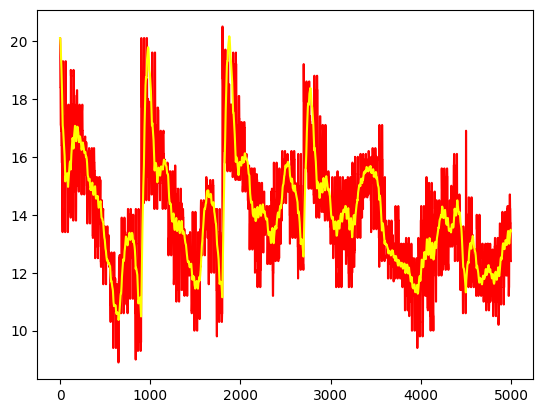

In [92]:
plt.plot(df[0:5000]['wind_speed'], color='red')
plt.plot(experiment_df['wind_speed'], color='yellow')

In [93]:
df['wind_speed'] = double_exponential_smoothing(df['wind_speed'], 0.025, 0.045)

In [94]:
TREND_A, TREND_B = np.polyfit(list(df['hour']), list(df['wind_speed']), 1)
TREND_A, TREND_B

(-0.17153278970544686, 16.41080898931604)

In [95]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, first_column_name, second_column_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series[first_column_name]
  # xs = np.arange(len(series))
  ys = series[second_column_name]

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])
  plt.plot(xs, TREND_A * xs + TREND_B)


def plot_first_vs_second(first_column, second_column, hour_threshold):
  fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
  df_sorted = df[df['hour'] > hour_threshold].sort_values('hour', ascending=True)
  _plot_series(df_sorted, '', first_column, second_column)
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(first_column)
  _ = plt.ylabel(second_column)

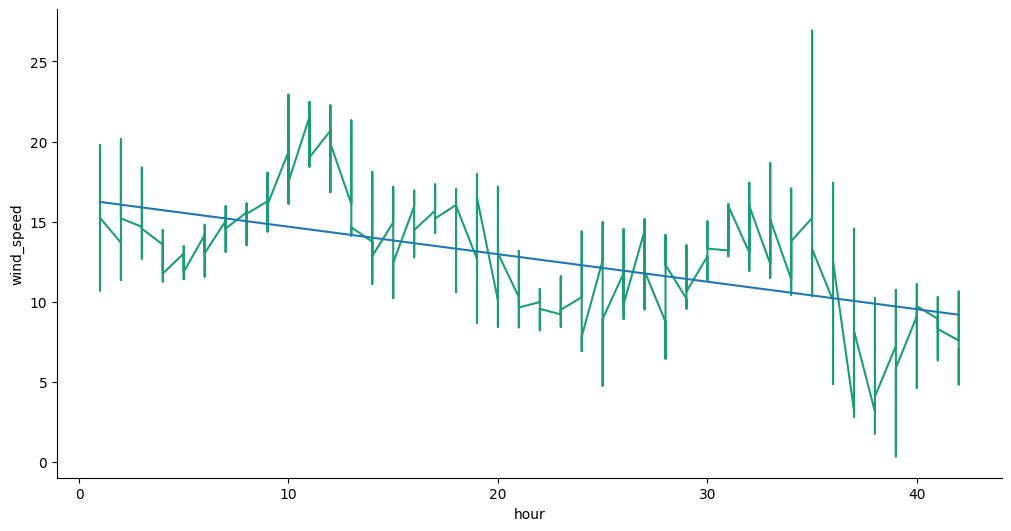

In [96]:
# @title hour vs wind_speed
plot_first_vs_second('hour', 'wind_speed', 0)

In [97]:
df['wind_speed'] -= TREND_A * df['hour']

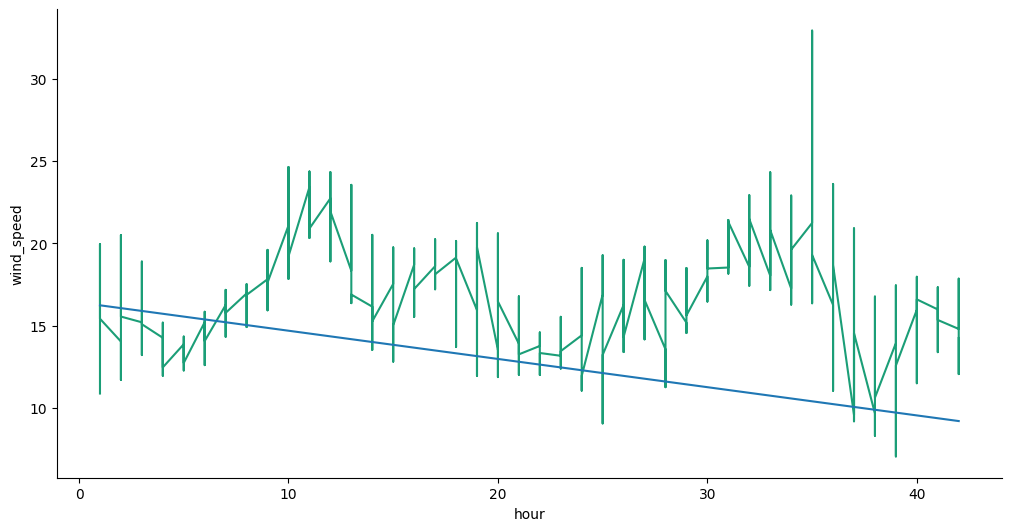

In [98]:
plot_first_vs_second('hour', 'wind_speed', 0)

In [99]:
def get_neighboring_cells(row, col, height, width, k_neighbors):
  '''
    returning 9 heighboring cells
  '''

  assert(k_neighbors % 2 == 1)
  start = k_neighbors // 2
  startx = min(max(0, row - start), height - k_neighbors)
  starty = min(max(0, col - start), width - k_neighbors)

  neighbors = set()
  for i in range(startx, startx + k_neighbors):
    for j in range(starty, starty + k_neighbors):
      if i == row and j == col:
        continue

      neighbors.add((i, j))

  to_remove = list()
  for item in neighbors:
    if item[0] < 0 or item[0] >= height or item[1] < 0 or item[1] >= width:
      to_remove.append(item)

  for item in to_remove:
    neighbors.remove(item)



  return sorted(neighbors)

In [100]:
K_WINDOW = 35
K_NEIGHBORS = 11

def get_wind_speed_features(wind_speed, hour, curr_row, curr_col, add_target=True):
  neighbors = get_neighboring_cells(curr_row, curr_col, 30, 30, K_NEIGHBORS)

  new_features = list()

  if add_target:
    new_features.append(wind_speed[hour][curr_row][curr_col] - TREND_A * hour)

  for k in range(K_WINDOW, 0, -1):
    new_features.append(wind_speed[hour - k][curr_row][curr_col] - TREND_A * (hour - k))

  for k in range(K_WINDOW, 0, -1):
    for j in range(len(neighbors)):
      new_features.append(wind_speed[hour - k][neighbors[j][0]][neighbors[j][1]] - TREND_A * (hour - k))
      new_features.append(np.sin(wind_speed[hour - k][neighbors[j][0]][neighbors[j][1]] - TREND_A * (hour - k)))
      new_features.append(np.cos(wind_speed[hour - k][neighbors[j][0]][neighbors[j][1]] - TREND_A * (hour - k)))

  return new_features

In [104]:
def gen_column_names(add_target=True, add_hour=True):
  columns = list()
  start_name = "wind_speed"

  if add_target:
    columns.append(f"{start_name}_0")

  for k in range(K_WINDOW, 0, -1):
    columns.append(f"{start_name}_0_{k}")

  for k in range(K_WINDOW, 0, -1):
    for j in range(K_NEIGHBORS * K_NEIGHBORS - 1):
      columns.append(f"{start_name}_{j + 1}_{k}")
      columns.append(f"sin_{start_name}_{j + 1}_{k}")
      columns.append(f"cos_{start_name}_{j + 1}_{k}")

  return columns

In [ ]:
new_data = list()

for hour in range(43):
  if (hour < K_WINDOW):
    continue

  for row in range(30):
    for col in range(30):
      new_data.append(get_wind_speed_features(wind_speed, hour, row, col, True))

In [ ]:
new_train_df = pd.DataFrame(data=new_data, columns=gen_column_names())
new_train_df

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(new_train_df.drop(["wind_speed_0"], axis=1), new_train_df["wind_speed_0"],
                                                  shuffle=True, random_state=42, train_size=0.8)

In [ ]:
X_val

In [61]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [68]:
model = CatBoostRegressor(iterations=200, learning_rate=0.1, loss_function="MAPE", task_type="GPU",
                           devices='0')

In [69]:
model.fit(X_train, y_train, verbose=50)

0:	learn: 0.2093076	total: 223ms	remaining: 44.3s
50:	learn: 0.1951396	total: 6.25s	remaining: 18.3s
100:	learn: 0.1818843	total: 11.8s	remaining: 11.5s
150:	learn: 0.1695392	total: 18.1s	remaining: 5.89s
199:	learn: 0.1584036	total: 23.8s	remaining: 0us


In [70]:
mean_absolute_percentage_error(y_val, model.predict(X_val))

0.15348494187238973

In [71]:
model.get_feature_importance(prettified=True).set_index('Feature Id')

,Importances
Feature Id,
wind_speed_100_27,11.540676
wind_speed_93_27,8.409818
wind_speed_11_12,5.447622
wind_speed_101_27,5.285898
wind_speed_22_12,4.133704
...,...
cos_wind_speed_118_1,0.000000
sin_wind_speed_119_1,0.000000
cos_wind_speed_119_1,0.000000


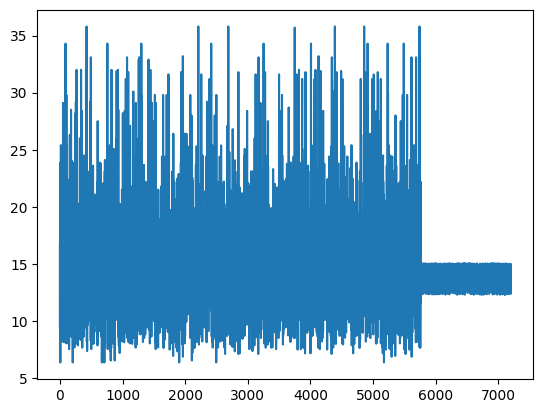

In [72]:
plt.plot(
    (list(y_train) + list(model.predict(X_val)))
)

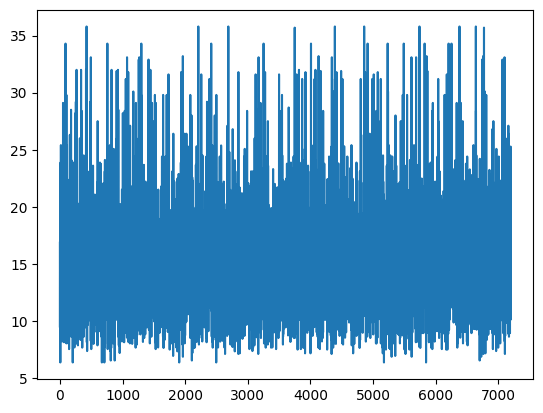

In [73]:
plt.plot(
    (list(y_train) + list(y_val))
)

Testing

In [74]:
new_train_df

,wind_speed_0,wind_speed_0_35,wind_speed_0_34,wind_speed_0_33,wind_speed_0_32,wind_speed_0_31,wind_speed_0_30,wind_speed_0_29,wind_speed_0_28,wind_speed_0_27,...,sin_wind_speed_116_1,cos_wind_speed_116_1,sin_wind_speed_117_1,cos_wind_speed_117_1,sin_wind_speed_118_1,cos_wind_speed_118_1,sin_wind_speed_119_1,cos_wind_speed_119_1,sin_wind_speed_120_1,cos_wind_speed_120_1
0,18.803648,20.10000,20.271533,20.843066,19.714599,15.986131,17.757664,19.029197,16.800730,16.572262,...,0.278814,0.960345,0.278814,0.960345,0.278814,0.960345,0.278814,0.960345,0.278814,0.960345
1,18.803648,20.10000,20.271533,20.843066,19.714599,15.986131,17.757664,19.029197,16.800730,16.572262,...,0.278814,0.960345,0.278814,0.960345,0.278814,0.960345,0.278814,0.960345,0.278814,0.960345
2,18.803648,20.10000,20.271533,20.843066,19.714599,15.986131,17.757664,19.029197,16.800730,16.572262,...,0.278814,0.960345,0.278814,0.960345,0.278814,0.960345,0.278814,0.960345,0.278814,0.960345
3,18.103648,18.40000,19.071532,19.043066,18.414598,13.886131,14.857664,15.929196,15.300730,14.672263,...,0.278814,0.960345,0.278814,0.960345,0.278814,0.960345,0.278814,0.960345,0.278814,0.960345
4,18.103648,18.40000,19.071532,19.043066,18.414598,13.886131,14.857664,15.929196,15.300730,14.672263,...,0.278814,0.960345,0.278814,0.960345,0.278814,0.960345,0.278814,0.960345,0.278814,0.960345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7195,16.504377,14.80073,17.072262,18.443795,24.515327,19.786860,21.958393,20.529926,22.301459,19.872991,...,-0.854652,-0.519201,-0.591990,0.805945,-0.591990,0.805945,-0.591990,0.805945,-0.591990,0.805945
7196,12.604377,14.20073,16.272262,18.443795,25.115328,19.386861,24.158394,22.529926,21.201458,18.372992,...,-0.854652,-0.519201,-0.854652,-0.519201,-0.591990,0.805945,-0.591990,0.805945,-0.591990,0.805945
7197,12.604377,14.20073,16.272262,18.443795,25.115328,19.386861,24.158394,22.529926,21.201458,18.372992,...,-0.854652,-0.519201,-0.854652,-0.519201,-0.591990,0.805945,-0.591990,0.805945,-0.591990,0.805945
7198,12.604377,14.20073,16.272262,18.443795,25.115328,19.386861,24.158394,22.529926,21.201458,18.372992,...,-0.854652,-0.519201,-0.854652,-0.519201,-0.591990,0.805945,-0.591990,0.805945,-0.591990,0.805945


In [106]:
test_model = CatBoostRegressor(iterations=200, learning_rate=0.1, loss_function="MAPE", task_type="GPU",
                           devices='0:4')
test_model.fit(new_train_df.drop(["wind_speed_0"], axis=1), new_train_df["wind_speed_0"], verbose=50)

0:	learn: 0.2080203	total: 179ms	remaining: 35.6s
50:	learn: 0.1939569	total: 6.03s	remaining: 17.6s
100:	learn: 0.1807808	total: 11.9s	remaining: 11.7s
150:	learn: 0.1683500	total: 17.7s	remaining: 5.75s
199:	learn: 0.1571962	total: 23.9s	remaining: 0us


In [107]:
def get_dataset_for_curr_hour(hour, wind_speed):
  data = list()

  for row in range(30):
    for col in range(30):
      data.append(get_wind_speed_features(wind_speed, hour, row, col, False))

  return data

In [108]:
wind_speed_copy = copy.deepcopy(wind_speed)

In [109]:
def update_wind_speed(pred_prev_hour):
  matrix = list()

  idx = 0
  for row in range(30):
    matrix.append(list())
    for col in range(30):
      matrix[row].append(pred_prev_hour[idx])
      ++idx

  return np.append(wind_speed_copy, np.array([matrix]), axis=0)

In [110]:
preds = list()

for hour in range(43, 48):
  preds.append(test_model.predict(get_dataset_for_curr_hour(hour, wind_speed_copy)))
  wind_speed_copy = update_wind_speed(preds[-1])

In [111]:
solution = pd.read_csv("/content/solution_best.csv")

In [112]:
solution

,ID,temperature,pressure,humidity,wind_speed,wind_dir,cloud_cover
0,0,22.563476,1001.821547,82.926331,7.5,14,41.765790
1,1,22.852261,1001.851164,82.922356,7.5,14,40.699017
2,2,22.670904,1001.844527,83.112951,7.5,14,41.947514
3,3,21.811013,1002.107676,81.607947,7.5,14,41.901353
4,4,21.599134,1002.108206,81.818363,7.5,14,40.734060
...,...,...,...,...,...,...,...
4495,4495,18.085634,1001.711449,82.102343,7.5,14,31.717644
4496,4496,18.484323,1001.703269,79.985005,7.5,14,31.702989
4497,4497,18.415131,1001.703269,81.206745,7.5,14,32.232037
4498,4498,18.438263,1001.707569,82.199181,7.5,14,32.821132


In [113]:
result = list()
hours = [43, 44, 45, 46, 47]

for i in range(len(preds)):
  result += list(preds[i] + TREND_A * hours[i])

print(len(result))

4500


In [114]:
result[:10]

[7.0756653586843195,
 7.0756653586843195,
 7.0756653586843195,
 7.071905890710014,
 7.071905890710014,
 7.071905890710014,
 7.081187536101653,
 7.104900675438558,
 7.117489461996457,
 7.145927933690701]

In [115]:
solution['wind_speed'] = result
solution

,ID,temperature,pressure,humidity,wind_speed,wind_dir,cloud_cover
0,0,22.563476,1001.821547,82.926331,7.075665,14,41.765790
1,1,22.852261,1001.851164,82.922356,7.075665,14,40.699017
2,2,22.670904,1001.844527,83.112951,7.075665,14,41.947514
3,3,21.811013,1002.107676,81.607947,7.071906,14,41.901353
4,4,21.599134,1002.108206,81.818363,7.071906,14,40.734060
...,...,...,...,...,...,...,...
4495,4495,18.085634,1001.711449,82.102343,6.093663,14,31.717644
4496,4496,18.484323,1001.703269,79.985005,6.093663,14,31.702989
4497,4497,18.415131,1001.703269,81.206745,6.093663,14,32.232037
4498,4498,18.438263,1001.707569,82.199181,6.093663,14,32.821132


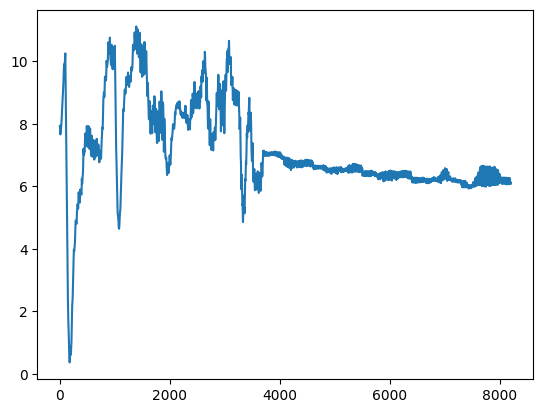

In [116]:
plt.plot(
    (list(df['wind_speed'] + TREND_A * df['hour']) + list(solution['wind_speed']))[35000:]
)

In [117]:

solution.to_csv("last_solution.csv", index=False)